## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [42]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
%matplotlib inline

In [43]:
def show_images(images, cols = 4, rows = 5, figsize=(15,10), out_dir = None, cmap = None):
    """
    Display `images`
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            img = images[index][1]
            image_name = images[index][0]
            # write image
            if out_dir is not None:
                out_path = os.path.join(out_dir, image_name)
                cv2.imwrite(out_path, img)
            # show image
            if cmap == None:
                ax.imshow(img)
            else:
                ax.imshow(img, cmap=cmap)
            ax.set_title(image_name)
            ax.axis('off')

## Camera calibration matrix and distortion coefficients already calculated

In [44]:
# Load undistortion matrix
with open('./camera_cal/camera_calibration_mat.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

## Apply a distortion correction to raw images.

In [45]:
# Load test images
images_file = glob.glob('./test_images/*.jpg')
images_test = []
for fname in images_file:
    img_name = os.path.split(fname)[1]
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    images_test.append((img_name, img))

In [46]:
# Undistortion
def undistort(img, mtx=mtx, dist=dist):
    return cv2.undistort(img, mtx, dist, None, mtx)
# apply undistortion
images_undistort = []
for item in images_test:
    images_undistort.append((item[0], undistort(item[1], mtx, dist)))

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [47]:
# To HLS color space
def to_hls(img, channel=2):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls[:,:,channel]
# Apply color space
images_colorspace = []
for item in images_undistort:
    images_colorspace.append((item[0], to_hls(item[1])))

In [48]:
# Binary threshold images
def binary(img, thresh=(0, 255)):
    xbinary = np.zeros_like(img)
    xbinary[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return xbinary

# Sobel along orient x or y
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        yorder = 0
        xorder = 1
    elif orient == 'y':
        yorder = 1
        xorder = 0
    else:
        print('wrong orient!')
        return None
        
    sobel = cv2.Sobel(img, cv2.CV_64F, xorder, yorder, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255.0*abs_sobel/np.max(abs_sobel))
    return binary(scaled, thresh)

# Calculate gradient magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):   
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    mag_binary = binary(gradmag, mag_thresh)
    return mag_binary

# Calculate gradient direction
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = binary(absgraddir, dir_thresh)
    return dir_binary

# combination
def combineGradients(sobel_x, sobel_y, sobel_mag, sobel_dir):
    """
    Compute the combination of Sobel X and Sobel Y or Magnitude and Direction
    """
    combined = np.zeros_like(sobel_x) 
    # combined[((sobel_x == 1) & (sobel_y == 1)) | ((sobel_mag == 1) & (sobel_dir == 1))] = 1
    combined[(sobel_x == 1) & (sobel_y == 1)] = 1     ## better than above
    return combined

images_combination = []
for i in range(len(images_colorspace)):
    fname = images_colorspace[i][0]
    img = images_colorspace[i][1]
    sobel_x = abs_sobel_thresh(img, orient='x', thresh = (10, 160))
    sobel_y = abs_sobel_thresh(img, orient='y', thresh = (10, 160))
    sobel_mag = mag_thresh(img, mag_thresh = (5, 160))
    sobel_dir = dir_threshold(img, dir_thresh = (0.79, 1.20))
    sobel_combined = combineGradients(sobel_x, sobel_y, sobel_mag, sobel_dir)
    images_combination.append((fname, sobel_combined))

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [49]:
# Load perspective transformation matrix
with open('./camera_cal/perspective_transform_mat.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    M = dist_pickle["M"]
    Minv = dist_pickle["Minv"]

In [50]:
def perspective_transform(img, M=M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

# Apply perspective transform
images_perspective_transform = []
for item in images_combination:
    images_perspective_transform.append((item[0], perspective_transform(item[1], M)))

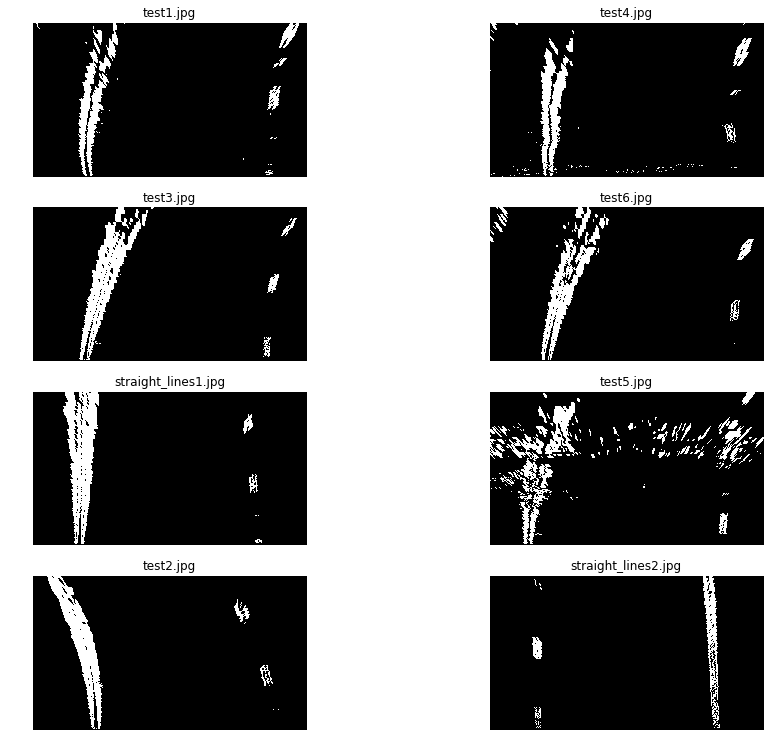

In [51]:
show_images(images_perspective_transform, 2, 4, (15, 13), out_dir='./output_images/perspective_transform/', cmap='gray')

## Detect lane pixels and fit to find the lane boundary.

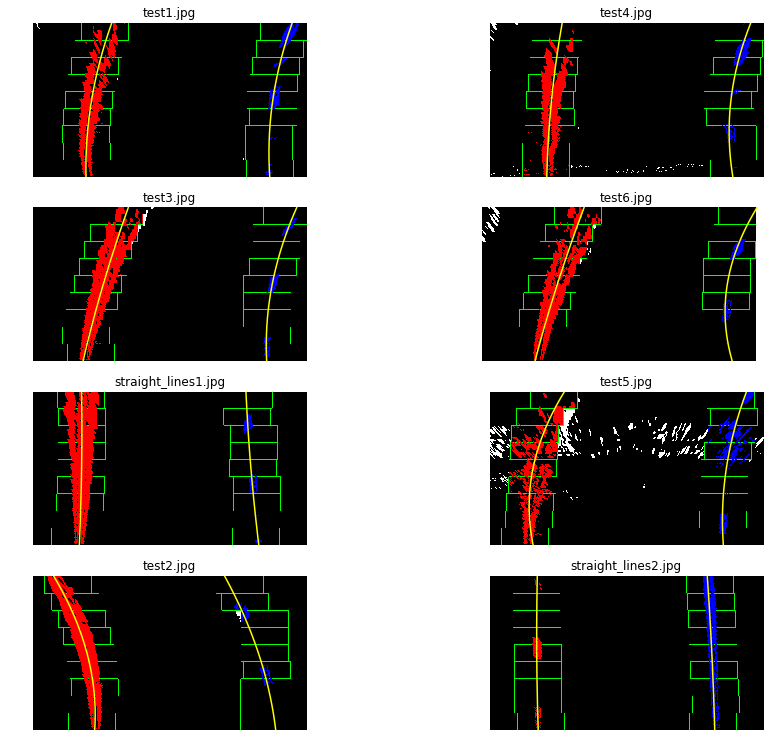

In [52]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def findLines(image, nwindows=9, margin=110, minpix=50):   
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def visualizeLanes(image, ax):
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLines(image)
    # Visualization
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    ax.imshow(out_img)
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    return ( left_fit, right_fit, left_fit_m, right_fit_m, out_img )

def showLaneOnImages(images, cols = 2, rows = 4, figsize=(15,13)):
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    imageAndFit = []
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            left_fit, right_fit, left_fit_m, right_fit_m, out_img = visualizeLanes(image, ax)
            ax.set_title(imagePathName)
            ax.axis('off')
            imageAndFit.append( ( imagePathName, left_fit, right_fit, left_fit_m, right_fit_m, out_img ) )
    return imageAndFit

images_poly = showLaneOnImages(images_perspective_transform)
# write image
for item in images_poly:
    image_name = item[0]
    out_img = item[-1]
    out_path = os.path.join('./output_images/detect_lane_pixels/', image_name)
    cv2.imwrite(out_path, out_img)

## Determine the curvature of the lane and vehicle position with respect to center.

In [53]:
def calculateCurvature(yRange, left_fit_cr):
    """
    Returns the curvature of the polynomial `fit` on the y range `yRange`.
    """
    
    return ((1 + (2*left_fit_cr[0]*yRange*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])

for item in images_poly:
    imagePath, left_fit, right_fit, left_fit_m, right_fit_m, _ = item
    yRange = 719
    leftCurvature = calculateCurvature(yRange, left_fit_m) / 1000
    rightCurvature = calculateCurvature(yRange, right_fit_m) / 1000
    print('Image : {}, Left : {:.2f} km, Right : {:.2f} km'.format(imagePath, leftCurvature, rightCurvature))

Image : test1.jpg, Left : 0.63 km, Right : 0.56 km
Image : test4.jpg, Left : 1.54 km, Right : 0.42 km
Image : test3.jpg, Left : 1.88 km, Right : 0.48 km
Image : test6.jpg, Left : 2.06 km, Right : 0.26 km
Image : straight_lines1.jpg, Left : 3.96 km, Right : 3.08 km
Image : test5.jpg, Left : 0.29 km, Right : 0.53 km
Image : test2.jpg, Left : 0.36 km, Right : 0.55 km
Image : straight_lines2.jpg, Left : 4.49 km, Right : 5.52 km


## Warp the detected lane boundaries back onto the original image.

In [54]:
def drawLine(img, left_fit, right_fit):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

def drawLaneOnImage(img_perspective_transform, img_test):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img_perspective_transform)
    output = drawLine(img_test, left_fit, right_fit)
    return output

# Apply pipeline 
images_result = []
for i in range(len(images_perspective_transform)):
    img_test = images_test[i][1]
    img_perspective_transform = images_perspective_transform[i][1]
    images_result.append((images_test[i][0], drawLaneOnImage(img_perspective_transform, img_test)))

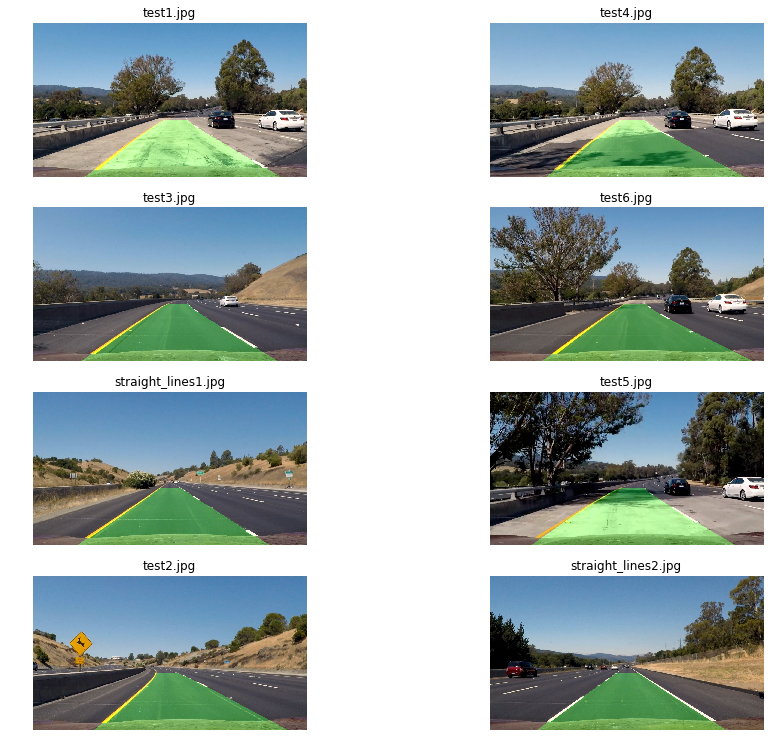

In [55]:
show_images(images_result, 2, 4, (15, 13), out_dir='./output_images/lane_detection/')

## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [56]:
def pipeline(img_perspective_transform, img_test, fontScale=2):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img_perspective_transform)
    output = drawLine(img_test, left_fit, right_fit)
    
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    return output

# Apply final pipeline 
images_final_result = []
for i in range(len(images_perspective_transform)):
    img_test = images_test[i][1]
    img_perspective_transform = images_perspective_transform[i][1]
    images_final_result.append((images_test[i][0], pipeline(img_perspective_transform, img_test)))

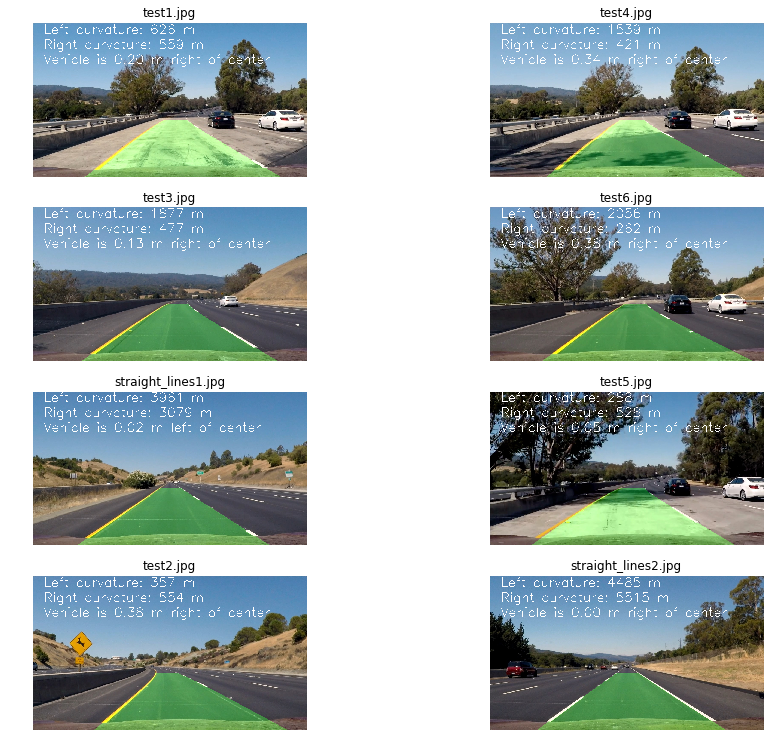

In [57]:
show_images(images_final_result, 2, 4, (15, 13), out_dir='./output_images/final_result/')

## Video pipeline

In [32]:
from moviepy.editor import VideoFileClip

In [39]:
class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None

def calculateLanes(img):
    """
    Calculates the lane on image `img`.
    """
    img_undistort = undistort(img, mtx, dist)
    img_hls = to_hls(img_undistort)
    img_sobel_x = abs_sobel_thresh(img_hls, orient='x', thresh = (10, 160))
    img_sobel_y = abs_sobel_thresh(img_hls, orient='y', thresh = (10, 160))
    img_sobel_mag = mag_thresh(img_hls, mag_thresh = (5, 160))
    img_sobel_dir = dir_threshold(img_hls, dir_thresh = (0.79, 1.20))
    img_sobel_combined = combineGradients(img_sobel_x, img_sobel_y, img_sobel_mag, img_sobel_dir)
    img_perspective_transform = perspective_transform(img_sobel_combined)
    
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img_perspective_transform)
    # Calculate curvature
    leftCurvature = calculateCurvature(yRange, left_fit_m) 
    rightCurvature = calculateCurvature(yRange, right_fit_m)
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

def displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle):
    """
    Display the lanes information on the image.
    """
    output = drawLine(img, left_fit, right_fit)
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(leftCurvature), (50, 50), font, 1, fontColor, 2)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(rightCurvature), (50, 120), font, 1, fontColor, 2)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 1, fontColor, 2)
    return output
    
def videoPipeline(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    
    leftLane = Lane()
    rightLane = Lane()
    
    def processImage(img):
        left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle = calculateLanes(img)
        if leftCurvature > 10000:
            left_fit = leftLane.left_fit
            left_fit_m = leftLane.left_fit_m
            leftCurvature = leftLane.leftCurvature
        else:
            leftLane.left_fit = left_fit
            leftLane.left_fit_m = left_fit_m
            leftLane.leftCurvature = leftCurvature
        
        if rightCurvature > 10000:
            right_fit = rightLane.right_fit
            right_fit_m = rightLane.right_fit_m
            rightCurvature = rightLane.rightCurvature
        else:
            rightLane.right_fit = right_fit
            rightLane.right_fit_m = right_fit_m
            rightLane.rightCurvature = rightCurvature
            
        return displayLanes(img, left_fit, right_fit, left_fit_m, right_fit_m, leftCurvature, rightCurvature, diffFromVehicle)

    clip = myclip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

In [34]:
# Project video
videoPipeline('project_video.mp4', 'output_images/project_video.mp4')

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [02:26<00:00,  8.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 



In [41]:
# Project video
videoPipeline('harder_challenge_video.mp4', 'output_images/harder_challenge_video.mp4')

[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4




  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 1/1200 [00:00<03:25,  5.84it/s]

  0%|          | 2/1200 [00:00<03:25,  5.84it/s]

  0%|          | 3/1200 [00:00<03:22,  5.91it/s]

  0%|          | 4/1200 [00:00<03:07,  6.37it/s]

  0%|          | 5/1200 [00:00<03:02,  6.54it/s]

  0%|          | 6/1200 [00:00<02:53,  6.88it/s]

  1%|          | 7/1200 [00:01<02:52,  6.92it/s]

  1%|          | 8/1200 [00:01<02:45,  7.22it/s]

  1%|          | 9/1200 [00:01<02:45,  7.19it/s]

  1%|          | 10/1200 [00:01<02:40,  7.43it/s]

  1%|          | 11/1200 [00:01<02:50,  6.96it/s]

  1%|          | 12/1200 [00:01<02:52,  6.91it/s]

  1%|          | 13/1200 [00:01<02:58,  6.64it/s]

  1%|          | 14/1200 [00:02<02:57,  6.69it/s]

  1%|▏         | 15/1200 [00:02<03:01,  6.54it/s]

  1%|▏         | 16/1200 [00:02<02:55,  6.76it/s]

  1%|▏         | 17/1200 [00:02<02:51,  6.89it/s]

  2%|▏         | 18/1200 [00:02<02:43,  7.24it/s]

  2%|▏         | 19/1200 [00:02<02:43,  7.23it/

 24%|██▎       | 284/1200 [00:37<01:56,  7.83it/s]

 24%|██▍       | 285/1200 [00:37<01:58,  7.75it/s]

 24%|██▍       | 286/1200 [00:38<01:54,  7.98it/s]

 24%|██▍       | 287/1200 [00:38<01:56,  7.81it/s]

 24%|██▍       | 288/1200 [00:38<01:53,  8.01it/s]

 24%|██▍       | 289/1200 [00:38<01:59,  7.63it/s]

 24%|██▍       | 290/1200 [00:38<01:57,  7.77it/s]

 24%|██▍       | 291/1200 [00:38<02:00,  7.57it/s]

 24%|██▍       | 292/1200 [00:38<01:58,  7.67it/s]

 24%|██▍       | 293/1200 [00:38<02:01,  7.48it/s]

 24%|██▍       | 294/1200 [00:39<01:59,  7.59it/s]

 25%|██▍       | 295/1200 [00:39<02:03,  7.36it/s]

 25%|██▍       | 296/1200 [00:39<02:02,  7.40it/s]

 25%|██▍       | 297/1200 [00:39<02:04,  7.24it/s]

 25%|██▍       | 298/1200 [00:39<02:02,  7.36it/s]

 25%|██▍       | 299/1200 [00:39<02:03,  7.30it/s]

 25%|██▌       | 300/1200 [00:39<02:01,  7.42it/s]

 25%|██▌       | 301/1200 [00:40<02:02,  7.36it/s]

 25%|██▌       | 302/1200 [00:40<01:58,  7.59it/s]

 25%|██▌    

 47%|████▋     | 566/1200 [01:14<01:16,  8.33it/s]

 47%|████▋     | 567/1200 [01:14<01:16,  8.24it/s]

 47%|████▋     | 568/1200 [01:14<01:16,  8.26it/s]

 47%|████▋     | 569/1200 [01:15<01:17,  8.19it/s]

 48%|████▊     | 570/1200 [01:15<01:14,  8.47it/s]

 48%|████▊     | 571/1200 [01:15<01:15,  8.34it/s]

 48%|████▊     | 572/1200 [01:15<01:13,  8.59it/s]

 48%|████▊     | 573/1200 [01:15<01:14,  8.43it/s]

 48%|████▊     | 574/1200 [01:15<01:12,  8.65it/s]

 48%|████▊     | 575/1200 [01:15<01:13,  8.45it/s]

 48%|████▊     | 576/1200 [01:15<01:12,  8.65it/s]

 48%|████▊     | 577/1200 [01:15<01:16,  8.14it/s]

 48%|████▊     | 578/1200 [01:16<01:16,  8.17it/s]

 48%|████▊     | 579/1200 [01:16<01:19,  7.85it/s]

 48%|████▊     | 580/1200 [01:16<01:17,  7.98it/s]

 48%|████▊     | 581/1200 [01:16<01:19,  7.74it/s]

 48%|████▊     | 582/1200 [01:16<01:18,  7.92it/s]

 49%|████▊     | 583/1200 [01:16<01:20,  7.71it/s]

 49%|████▊     | 584/1200 [01:16<01:18,  7.89it/s]

 49%|████▉  

 71%|███████   | 848/1200 [01:51<00:46,  7.65it/s]

 71%|███████   | 849/1200 [01:51<00:46,  7.51it/s]

 71%|███████   | 850/1200 [01:51<00:45,  7.66it/s]

 71%|███████   | 851/1200 [01:51<00:46,  7.54it/s]

 71%|███████   | 852/1200 [01:52<00:45,  7.65it/s]

 71%|███████   | 853/1200 [01:52<00:47,  7.25it/s]

 71%|███████   | 854/1200 [01:52<00:49,  6.99it/s]

 71%|███████▏  | 855/1200 [01:52<00:48,  7.05it/s]

 71%|███████▏  | 856/1200 [01:52<00:47,  7.31it/s]

 71%|███████▏  | 857/1200 [01:52<00:47,  7.25it/s]

 72%|███████▏  | 858/1200 [01:52<00:45,  7.45it/s]

 72%|███████▏  | 859/1200 [01:53<00:46,  7.36it/s]

 72%|███████▏  | 860/1200 [01:53<00:44,  7.56it/s]

 72%|███████▏  | 861/1200 [01:53<00:45,  7.42it/s]

 72%|███████▏  | 862/1200 [01:53<00:44,  7.55it/s]

 72%|███████▏  | 863/1200 [01:53<00:45,  7.42it/s]

 72%|███████▏  | 864/1200 [01:53<00:44,  7.50it/s]

 72%|███████▏  | 865/1200 [01:53<00:45,  7.41it/s]

 72%|███████▏  | 866/1200 [01:53<00:44,  7.57it/s]

 72%|███████

 94%|█████████▍| 1128/1200 [02:27<00:10,  7.06it/s]

 94%|█████████▍| 1129/1200 [02:28<00:10,  6.92it/s]

 94%|█████████▍| 1130/1200 [02:28<00:09,  7.10it/s]

 94%|█████████▍| 1131/1200 [02:28<00:09,  6.96it/s]

 94%|█████████▍| 1132/1200 [02:28<00:09,  7.10it/s]

 94%|█████████▍| 1133/1200 [02:28<00:09,  6.93it/s]

 94%|█████████▍| 1134/1200 [02:28<00:09,  7.05it/s]

 95%|█████████▍| 1135/1200 [02:28<00:09,  6.95it/s]

 95%|█████████▍| 1136/1200 [02:29<00:09,  7.10it/s]

 95%|█████████▍| 1137/1200 [02:29<00:08,  7.02it/s]

 95%|█████████▍| 1138/1200 [02:29<00:08,  7.16it/s]

 95%|█████████▍| 1139/1200 [02:29<00:08,  7.11it/s]

 95%|█████████▌| 1140/1200 [02:29<00:08,  7.31it/s]

 95%|█████████▌| 1141/1200 [02:29<00:08,  7.22it/s]

 95%|█████████▌| 1142/1200 [02:29<00:07,  7.41it/s]

 95%|█████████▌| 1143/1200 [02:29<00:07,  7.31it/s]

 95%|█████████▌| 1144/1200 [02:30<00:07,  7.42it/s]

 95%|█████████▌| 1145/1200 [02:30<00:07,  7.33it/s]

 96%|█████████▌| 1146/1200 [02:30<00:07,  7.47

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

